In [20]:
from mtcnn.mtcnn import  MTCNN
from sklearn.svm import SVC
from PIL import Image
import os
import pickle

from numpy import asarray, savez_compressed, load, expand_dims
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder,Normalizer


In [5]:
classes = os.listdir('dataset/train/')
print('Total classes: {} \n {}'.format(len(classes),classes))

Total classes: 9 
 ['BillieEilish', 'BuiAnhTuan', 'ChiPu', 'DonaldTrump', 'JustinBieber', 'NhietBa', 'SelenaGomez', 'SonTung', 'TaylorSwift']


In [6]:
detector = MTCNN()

# extract face bounding box from image
def extract_face(filename,required_size=(160,160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image) 
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    image.close()
    return face_array

# load face bounding box from image
def load_faces(directory):
    faces = list()
    #enumerate files
    for filename in os.listdir(directory):
        path = directory + filename 
        face = extract_face(path)
        faces.append(face)
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    x, y = list(), list()
    for subdir in os.listdir(directory):
        path = directory +'/' + subdir + '/'
        faces = load_faces(path) #load all cropped faces in the subdir
        labels = [subdir for _ in range(len(faces))] #create labels
        print('Load {} examples for class: {}'.format(len(faces), subdir))
        x.extend(faces)
        y.extend(labels)
    return asarray(x), asarray(y)

# create face embedding
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    #normalize pixel value across channel
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    #transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    #make prediction to get embedding | yhat is a vector
    yhat = model.predict(samples)
    return yhat[0]


In [7]:

# load train dataset
print('Loading train set')
trainX, trainY = load_dataset('dataset/train/')

# load test dataset
print('Loading test set')
testX, testY = load_dataset('dataset/val')

savez_compressed('faces_dataset.npz', trainX, trainY, testX, testY) #save to npz
print('Saved faces_dataset.npz')

Loading train set
1/1 [==============================] - 0s 20ms/step
Load 41 examples for class: BillieEilish
1/1 [==============================] - 0s 29ms/step
Load 28 examples for class: BuiAnhTuan
1/1 [==============================] - 0s 18ms/step
Load 53 examples for class: ChiPu
1/1 [==============================] - 0s 74ms/step
Load 13 examples for class: DonaldTrump
2/2 [==============================] - 0s 4ms/step
Load 65 examples for class: JustinBieber
1/1 [==============================] - 0s 26ms/step
Load 45 examples for class: NhietBa
2/2 [==============================] - 0s 4ms/step
Load 71 examples for class: SelenaGomez
1/1 [==============================] - 0s 23ms/step
Load 37 examples for class: SonTung
1/1 [==============================] - 0s 22ms/step
Load 33 examples for class: TaylorSwift
Loading test set
1/1 [==============================] - 0s 20ms/step
Load 18 examples for class: BillieEilish
1/1 [==============================] - 0s 24ms/step
Load 12

In [8]:
# load pre-trained model
model = load_model('model/facenet_keras.h5')

# convert each face in the train set to an embedding
print('Vetorizing train set')
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model,face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test to an embedding
print('Vetorizing test set')
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model,face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

savez_compressed('faces_dataset_embedding.npz', newTrainX, trainY, newTestX, testY)
print('Saved faces_dataset_embedding.npz')

Vetorizing train set
1/1 [==============================] - 0s 38ms/step
(386, 128)
Vetorizing test set
1/1 [==============================] - 0s 35ms/step
(169, 128)
Saved faces_dataset_embedding.npz


In [26]:
# load dataset
data = load('faces_dataset_embedding.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=386, test=169


In [27]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [28]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# Lưu mô hình vào file
filename = 'svm_model_faceRecog.sav'
pickle.dump(model, open(filename, 'wb'))

In [29]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=98.187, test=92.899


## Test với hình ảnh ngoài

In [32]:
from matplotlib import pyplot
def test_image(image_path, model, svm_model, out_encoder, in_encoder):
    # Trích xuất khuôn mặt
    face = extract_face(image_path)
    # Nếu không phát hiện được khuôn mặt, bỏ qua
    if face is None:
        print(f"Không tìm thấy khuôn mặt trong ảnh: {image_path}")
        return
    # Lấy embedding
    face_emb = get_embedding(model, face)
    # Chuẩn hóa embedding
    face_emb = in_encoder.transform(face_emb.reshape(1, -1))
    # Dự đoán
    yhat_class = svm_model.predict(face_emb)
    yhat_prob = svm_model.predict_proba(face_emb)
    # Lấy chỉ số và xác suất của lớp dự đoán
    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    # Chuyển đổi chỉ số lớp thành tên
    predict_names = out_encoder.inverse_transform(yhat_class)
    # In kết quả
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    # Hiển thị ảnh và kết quả
    pyplot.imshow(face)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()


1/1 [==============================] - 2s 2s/step
Predicted: DonaldTrump (84.511)


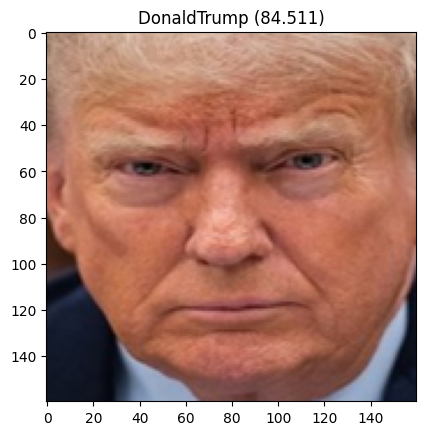

In [35]:
# Đường dẫn đến thư mục dataset/test
test_dir = 'dataset/test/'
svm_model = pickle.load(open('svm_model_faceRecog.sav', 'rb'))
faceNetModel = load_model('model/facenet_keras.h5')

test_image(test_dir + 'Donald-Trump.jpg', faceNetModel, svm_model, out_encoder, in_encoder)